### Импорт классов

In [1]:
!pip install lightgbm
!pip install xgboost
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

### Объявляем методы

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    считаем r^2 для тренировочных и валидационных данных и строим график предсказаний
    train_true_values - известные значения из тренировочного датасета
    train_pred_values - предсказаные значения из тренировочного датасета
    test_true_values -  известные значения из валидационного датасета
    test_pred_values -  предсказания
    """
    train_r2 = round(r2(train_true_values, train_pred_values), 3)
    test_r2 = round(r2(test_true_values, test_pred_values), 3)
    d_r2 = round((train_r2 - test_r2) * 100, 1)
    print("Train R2:\t" + str(train_r2))
    print("Test R2:\t" + str(test_r2))
    print("дельта R2:\t" + str(d_r2) + "%")

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
def read_csv(file_name):
    """
    Читаем файл csv
    file_name - имя csv файла лежащего в директории DATASET_PATH
    DATASET_PATH - констатнта, путь в котором лежат csv файлы
    """
    DATASET_PATH = 'data/'
    try:
        return pd.read_csv(DATASET_PATH + file_name + '.csv')
    except FileNotFoundError:
        print('Файл ' + file_name + '.csv не найден!')

In [6]:
def load_data():
    global train_df
    global test_df
    train_df = read_csv('train')
    test_df = read_csv('test')

In [7]:
def prepear_data(df):
    """
    Готовим датасет к работе
    """
    df['Id'] = df['Id'].astype(str)
    df['DistrictId'] = df['DistrictId'].astype(str)
    return df

In [8]:
def show_hist(df, column='Price', figsize = (15, 5), bins=30):
    """
    Рисуем гистограмму
    df - датафрейм, на данных которого строим 
    column - столбец, по которому строим 
    figsize - размер графика
    bins - число столбцов
    """
    try:
        plt.figure(figsize=figsize)
        df[column].hist(bins=bins)
        plt.ylabel('Count')
        plt.xlabel(column)
        plt.title('Target distribution')
        plt.show()
    except KeyError:
        print('Параметра ' + column + ' нет в датасете')
    except TypeError:
        print('Неверный формат одного из параметров')
    except Exception:
        print('Ошибка!')

In [9]:
def cat_columns(df):
    """
    Анализируем Категориальные переменные датафрейма df
    """
    cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
    print(cat_colnames)
    for cat_colname in cat_colnames[2:]:
        print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [10]:
def room_show(df):
    print(df['Rooms'].value_counts())

In [11]:
def room_norm(df, bad_val):
    """
    Нормализуем количество комнат
    """
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    df.loc[df['Rooms'].isin(bad_val), 'Rooms'] = df['Rooms'].median()
    return df

In [12]:
def show_square(df):
    print(df[['Square', 'LifeSquare', 'KitchenSquare']].value_counts().sort_index())

In [13]:
def square_norm(df, test=False):
    """
    Нормализуем значения площадей
    """
    # для тренировочной выборки обрежем крайние знаяения
    if not test:
        for sq_param in ['Square', 'LifeSquare', 'KitchenSquare']:
            df = df[df[sq_param].isnull() |
                (df[sq_param] < df[sq_param].quantile(.99)) &
                (df[sq_param] > df[sq_param].quantile(.01))]
    # вычислим среднюю проч. площадь:
    square_med_diff = (df.loc[df['LifeSquare'].notnull(), 'Square'] -\
                   df.loc[df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   df.loc[df['LifeSquare'].notnull(), 'KitchenSquare']).median()
    # вычислим среднюю жилую площадь на одну комнату:
    life_square_per_rooms_med = (df.loc[df['LifeSquare'].notnull() & df['Rooms'] > 0, 'LifeSquare'] /\
                   df.loc[df['LifeSquare'].notnull() & df['Rooms'] > 0, 'Rooms']).median()
    # вычислим жилую площадь в местах пропуска:
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df.loc[df['LifeSquare'].isnull(), 'Rooms'] * life_square_per_rooms_med
    # вычислим жилую площадь в местах выброса(в 2 раза меньше ождаемой):
    df.loc[df['LifeSquare'] < life_square_per_rooms_med/2*df['Rooms'], 'LifeSquare'] = \
        df.loc[df['LifeSquare'] < life_square_per_rooms_med/2*df['Rooms'], 'Rooms'] * life_square_per_rooms_med
    # вычислим общую площадь в местах выброса:
    df.loc[df['Square'] < 10, 'Square'] = df.loc[df['Square'] < 10, 'LifeSquare'] + df.loc[df['Square'] < 10, 'KitchenSquare'] \
        + square_med_diff
    # площадь кухни не нормализую, так как она плохо заполнена и не должна оказывать существенного вляния при обучении
    return df

In [14]:
def floor_show(df):
    """
    Анализируем данные по этажности
    """
    print(df['Floor'].value_counts())
    print(df['HouseFloor'].value_counts())

In [15]:
def floor_norm(df, bad_val):
    """
    Нормализуем значения этажности
    """
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median() # если 0 этаж берем среднее
    df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = df['Floor'] # если этажность меньше этажа, повышаем этажность
    df.loc[df['HouseFloor'].isin(bad_val), 'HouseFloor'] = df['HouseFloor'].median()
    floor_outliers = df[df['Floor'] > df['HouseFloor']].index
    print(len(floor_outliers))
    return df

In [16]:
def house_year_show(df):
    """
    Анализируем данные по году постройки
    """
    print(df['HouseYear'].value_counts().sort_index())

In [17]:
def house_year_norm(df):
    """
    Нормализуем значения по году постройки
    """
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    return df

In [18]:
def show_healthcare1(df):
    """
    Анализируем данные healthcare1
    """
    print(df['Healthcare_1'].head())

In [19]:
def healthcare1_norm(df):
    """
    Нормализуем значения по Healthcare_1
    """
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    return df

In [20]:
def show_nulls(df):
    print(len(df) - df.count())

In [21]:
def ab_norm(df):
    for ab_param in ['Ecology_2', 'Ecology_3', 'Shops_2']:
        df[ab_param + '_bin'] = df[ab_param].replace({'A':0, 'B':1}).astype(int)
    return df

In [22]:
def district_add(df):
    district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
    return df

In [23]:
def med_price_by_district_add(df, df_train):
    price = df_train['Price'].mean() # средняя цена
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'}) # средняя цена от кол-ва комнат

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'}) # средняя цена от района

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели

In [24]:
load_data()

In [25]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [26]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [27]:
train_df = prepear_data(train_df)
test_df = prepear_data(test_df)

In [28]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Обзор данных

**Целевая переменная**

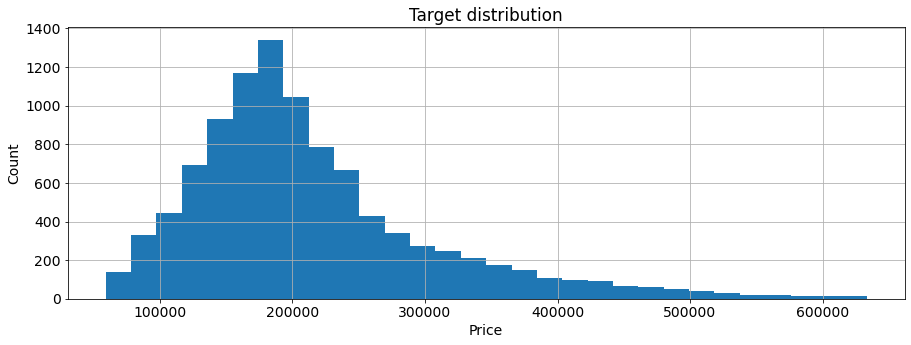

In [29]:
show_hist(train_df)

**Количественные переменные**

In [30]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [31]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**Категориальные переменные**

In [32]:
cat_columns(train_df)

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [33]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [34]:
cat_columns(test_df)

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']
Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [35]:
room_show(train_df)

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64


In [36]:
room_show(test_df)

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64


In [37]:
train_df = room_norm(train_df, [0, 10, 19])
room_show(train_df)

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64


In [38]:
test_df = room_norm(test_df, [0, 17])
room_show(test_df)

2.0    2031
1.0    1771
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64


**Square, LifeSquare, KitchenSquare**

In [39]:
train_df = square_norm(train_df)
train_df[['Square', 'LifeSquare']].describe()

,Square,LifeSquare
count,8881.000000,8881.000000
mean,54.809487,34.443134
std,16.225349,13.861567
min,29.719934,11.047605
25%,41.637555,22.401453
50%,51.656012,33.166810
75%,64.720916,43.533322
max,117.855969,103.978217


In [40]:
test_df = square_norm(test_df, test=True)
test_df[['Square', 'LifeSquare']].describe()

,Square,LifeSquare
count,5000.000000,5000.000000
mean,56.500763,35.872236
std,19.001739,16.575817
min,13.305531,9.495367
25%,41.912403,22.670819
50%,52.924953,34.155161
75%,66.289167,44.718963
max,223.453689,303.071094


**HouseFloor, Floor**

In [41]:
floor_show(train_df)

4     838
5     794
3     781
6     727
7     681
8     578
9     532
2     520
10    495
11    411
12    398
13    361
14    315
15    254
16    248
17    224
1     203
18    164
19    104
20     54
21     50
22     44
24     42
25     24
23     20
26      9
27      4
28      2
42      1
33      1
32      1
31      1
Name: Floor, dtype: int64
17.0     2058
9.0      1346
12.0     1021
5.0       991
14.0      621
16.0      558
1.0       435
22.0      313
25.0      302
24.0      154
8.0       136
10.0      121
4.0       105
15.0      100
20.0       88
19.0       86
3.0        74
18.0       74
7.0        54
6.0        46
23.0       37
2.0        29
21.0       28
13.0       26
11.0       24
30.0       18
0.0        14
27.0        5
32.0        3
40.0        2
99.0        2
39.0        2
45.0        1
26.0        1
44.0        1
29.0        1
28.0        1
117.0       1
37.0        1
48.0        1
Name: HouseFloor, dtype: int64


In [42]:
floor_show(test_df)

4     523
5     495
3     406
6     405
7     347
8     327
9     298
10    267
2     263
11    224
12    212
13    191
14    179
15    151
16    137
1     107
17    104
18     92
19     68
20     42
21     35
23     33
22     26
25     19
24     18
26     14
27      8
32      2
34      1
38      1
46      1
78      1
33      1
28      1
31      1
Name: Floor, dtype: int64
17.0    1151
9.0      724
5.0      550
12.0     526
14.0     344
16.0     235
1.0      230
22.0     193
25.0     179
0.0      131
24.0      98
8.0       72
3.0       69
10.0      64
4.0       58
19.0      51
15.0      49
20.0      48
18.0      44
6.0       35
7.0       28
2.0       26
23.0      22
13.0      13
11.0      11
40.0       9
21.0       9
27.0       5
30.0       5
26.0       4
48.0       3
32.0       2
37.0       2
28.0       2
39.0       2
34.0       1
31.0       1
33.0       1
99.0       1
29.0       1
36.0       1
Name: HouseFloor, dtype: int64


In [43]:
train_df = floor_norm(train_df, [99,117])

0


In [44]:
test_df = floor_norm(test_df, [99])

1


In [45]:
train_df[['HouseFloor', 'Floor']].describe()

,HouseFloor,Floor
count,8881.000000,8881.000000
mean,13.404346,8.446684
std,5.643989,5.133763
min,1.000000,1.000000
25%,9.000000,4.000000
50%,14.000000,7.000000
75%,17.000000,12.000000
max,48.000000,42.000000


In [46]:
test_df[['HouseFloor', 'Floor']].describe()

,HouseFloor,Floor
count,5000.000000,5000.000000
mean,13.484200,8.632000
std,6.027057,5.483228
min,1.000000,1.000000
25%,9.000000,4.000000
50%,14.000000,7.000000
75%,17.000000,12.000000
max,78.000000,78.000000


**HouseYear**

In [47]:
house_year_show(train_df)

1914          1
1916          1
1917          3
1918          4
1919          3
           ... 
2018        136
2019         57
2020         18
4968          1
20052011      1
Name: HouseYear, Length: 95, dtype: int64


In [48]:
house_year_show(test_df)

1908      1
1909      1
1910      1
1911      1
1912      1
       ... 
2016    172
2017    141
2018     73
2019     28
2020      9
Name: HouseYear, Length: 97, dtype: int64


In [49]:
train_df = house_year_norm(train_df)
house_year_show(train_df)

1914      1
1916      1
1917      3
1918      4
1919      3
       ... 
2016    243
2017    253
2018    136
2019     57
2020     20
Name: HouseYear, Length: 93, dtype: int64


In [50]:
show_nulls(train_df)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64


In [51]:
show_nulls(test_df)

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64


In [52]:
show_healthcare1(train_df)

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64


In [53]:
show_healthcare1(test_df)

0       NaN
1       NaN
2    4702.0
3       NaN
4       NaN
Name: Healthcare_1, dtype: float64


In [54]:
healthcare1_norm(train_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,990.0,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,6.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,990.0,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,17.329703,1.0,12,16.0,2015,0.072158,B,B,2,629,1,990.0,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808


In [55]:
healthcare1_norm(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B
1,15856,74,2.0,69.263183,35.066336,1.0,6,6.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,900.0,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,900.0,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,23.0,1989,0.090799,B,B,74,19083,2,900.0,5,15,B
4998,4780,62,2.0,81.305222,35.066336,0.0,4,12.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A


### Построение новых признаков

**Dummies**

In [56]:
train_df = ab_norm(train_df)

In [57]:
test_df = ab_norm(test_df)

In [58]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.00000
mean,1.884472,54.809487,34.443134,6.075329,8.446684,13.404346,1984.572233,0.119620,26.071163,5630.480014,8.403783,1079.740345,1.392636,4.438577,214939.479049,0.989979,0.969936,0.92940
std,0.797057,16.225349,13.861567,3.503611,5.133763,5.643989,18.373202,0.119654,17.269698,3977.902810,24.295214,763.680739,1.492092,4.837340,89654.209673,0.099610,0.170774,0.25617
min,1.000000,29.719934,11.047605,1.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.00000
25%,1.000000,41.637555,22.401453,1.000000,4.000000,9.000000,1972.000000,0.017647,10.000000,2370.000000,0.000000,810.000000,0.000000,1.000000,156934.440088,1.000000,1.000000,1.00000
50%,2.000000,51.656012,33.166810,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503,1.000000,1.000000,1.00000
75%,2.000000,64.720916,43.533322,9.000000,12.000000,17.000000,2000.000000,0.194489,36.000000,7614.000000,5.000000,1036.000000,3.000000,6.000000,250381.580780,1.000000,1.000000,1.00000
max,6.000000,117.855969,103.978217,14.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.00000


In [59]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.907400,56.500763,35.872236,5.976800,8.632000,13.484200,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600
std,0.810282,19.001739,16.575817,9.950018,5.483228,6.027057,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001
min,1.000000,13.305531,9.495367,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.912403,22.670819,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,52.924953,34.155161,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000
75%,2.000000,66.289167,44.718963,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000
max,6.000000,223.453689,303.071094,620.000000,78.000000,78.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000


**DistrictSize, IsDistrictLarge**

In [60]:
train_df = district_add(train_df)

# VC ~ размерность датасета

# VC(train + test)
# VC(normalize=True)
# VC(train).to_dict() -> train.map(dict), test.map(dict)
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
count,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.00000,8881.000000,8881.000000
mean,1.884472,54.809487,34.443134,6.075329,8.446684,13.404346,1984.572233,0.119620,26.071163,5630.480014,8.403783,1079.740345,1.392636,4.438577,214939.479049,0.989979,0.969936,0.92940,181.799460,0.443982
std,0.797057,16.225349,13.861567,3.503611,5.133763,5.643989,18.373202,0.119654,17.269698,3977.902810,24.295214,763.680739,1.492092,4.837340,89654.209673,0.099610,0.170774,0.25617,194.733542,0.496880
min,1.000000,29.719934,11.047605,1.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.00000,1.000000,0.000000
25%,1.000000,41.637555,22.401453,1.000000,4.000000,9.000000,1972.000000,0.017647,10.000000,2370.000000,0.000000,810.000000,0.000000,1.000000,156934.440088,1.000000,1.000000,1.00000,49.000000,0.000000
50%,2.000000,51.656012,33.166810,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503,1.000000,1.000000,1.00000,90.000000,0.000000
75%,2.000000,64.720916,43.533322,9.000000,12.000000,17.000000,2000.000000,0.194489,36.000000,7614.000000,5.000000,1036.000000,3.000000,6.000000,250381.580780,1.000000,1.000000,1.00000,279.000000,1.000000
max,6.000000,117.855969,103.978217,14.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.00000,628.000000,1.000000


In [61]:
test_df = district_add(test_df)

In [62]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.907400,56.500763,35.872236,5.976800,8.632000,13.484200,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600,115.537200,0.325000
std,0.810282,19.001739,16.575817,9.950018,5.483228,6.027057,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001,127.381882,0.468422
min,1.000000,13.305531,9.495367,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,41.912403,22.670819,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000,27.000000,0.000000
50%,2.000000,52.924953,34.155161,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,49.000000,0.000000
75%,2.000000,66.289167,44.718963,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000,257.000000,1.000000
max,6.000000,223.453689,303.071094,620.000000,78.000000,78.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,391.000000,1.000000


**MedPriceByDistrict**

In [63]:
# mean_price_by_rooms mean_price_dr
train_df = med_price_by_district_add(train_df, train_df)
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,mean_price_dr,mean_price_by_rooms
count,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,...,8881.000000,8881.000000,8881.000000,8881.000000,8881.000000,8881.00000,8881.000000,8881.000000,8881.000000,8881.000000
mean,1.884472,54.809487,34.443134,6.075329,8.446684,13.404346,1984.572233,0.119620,26.071163,5630.480014,...,1.392636,4.438577,214939.479049,0.989979,0.969936,0.92940,181.799460,0.443982,214939.479049,214939.479049
std,0.797057,16.225349,13.861567,3.503611,5.133763,5.643989,18.373202,0.119654,17.269698,3977.902810,...,1.492092,4.837340,89654.209673,0.099610,0.170774,0.25617,194.733542,0.496880,71905.275158,52088.851105
min,1.000000,29.719934,11.047605,1.000000,1.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,59174.778028,0.000000,0.000000,0.00000,1.000000,0.000000,78030.684516,161436.065794
25%,1.000000,41.637555,22.401453,1.000000,4.000000,9.000000,1972.000000,0.017647,10.000000,2370.000000,...,0.000000,1.000000,156934.440088,1.000000,1.000000,1.00000,49.000000,0.000000,166690.331246,161436.065794
50%,2.000000,51.656012,33.166810,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5562.000000,...,1.000000,3.000000,194240.534503,1.000000,1.000000,1.00000,90.000000,0.000000,199439.634859,216130.550208
75%,2.000000,64.720916,43.533322,9.000000,12.000000,17.000000,2000.000000,0.194489,36.000000,7614.000000,...,3.000000,6.000000,250381.580780,1.000000,1.000000,1.00000,279.000000,1.000000,248393.840446,216130.550208
max,6.000000,117.855969,103.978217,14.000000,42.000000,48.000000,2020.000000,0.521867,74.000000,19083.000000,...,6.000000,23.000000,633233.466570,1.000000,1.000000,1.00000,628.000000,1.000000,624156.003381,417636.145313


In [64]:
# mean_price_by_rooms mean_price_dr
test_df = med_price_by_district_add(test_df, train_df)
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,mean_price_dr,mean_price_by_rooms
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.907400,56.500763,35.872236,5.976800,8.632000,13.484200,1984.392600,0.119874,24.933800,5406.900000,...,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600,115.537200,0.325000,214023.628295,216415.464577
std,0.810282,19.001739,16.575817,9.950018,5.483228,6.027057,18.573149,0.120070,17.532202,4026.614773,...,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001,127.381882,0.468422,70668.634217,53257.714567
min,1.000000,13.305531,9.495367,0.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,78030.684516,161436.065794
25%,1.000000,41.912403,22.670819,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,...,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000,27.000000,0.000000,166690.331246,161436.065794
50%,2.000000,52.924953,34.155161,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,...,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,49.000000,0.000000,197741.406334,216130.550208
75%,2.000000,66.289167,44.718963,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,...,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000,257.000000,1.000000,246740.397977,216130.550208
max,6.000000,223.453689,303.071094,620.000000,78.000000,78.000000,2020.000000,0.521867,74.000000,19083.000000,...,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,391.000000,1.000000,593618.746096,417636.145313


### Разбиваем на тренировачную и валидационную выборки

In [65]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
new_feature_names = ['IsDistrictLarge', 'mean_price_by_rooms', 'mean_price_dr'] 
target_name = 'Price'
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Обучаем модель

In [66]:
from lightgbm import LGBMRegressor
def do_fit(X_train, y_train):
    best_model = LGBMRegressor(n_estimators = 80, max_depth = 5)
    best_model.fit(X_train, y_train)
    return best_model

In [67]:
best_model = do_fit(X_train, y_train)

### Делаем предсказание

Train R2:	0.851
Test R2:	0.723
дельта R2:	12.8%


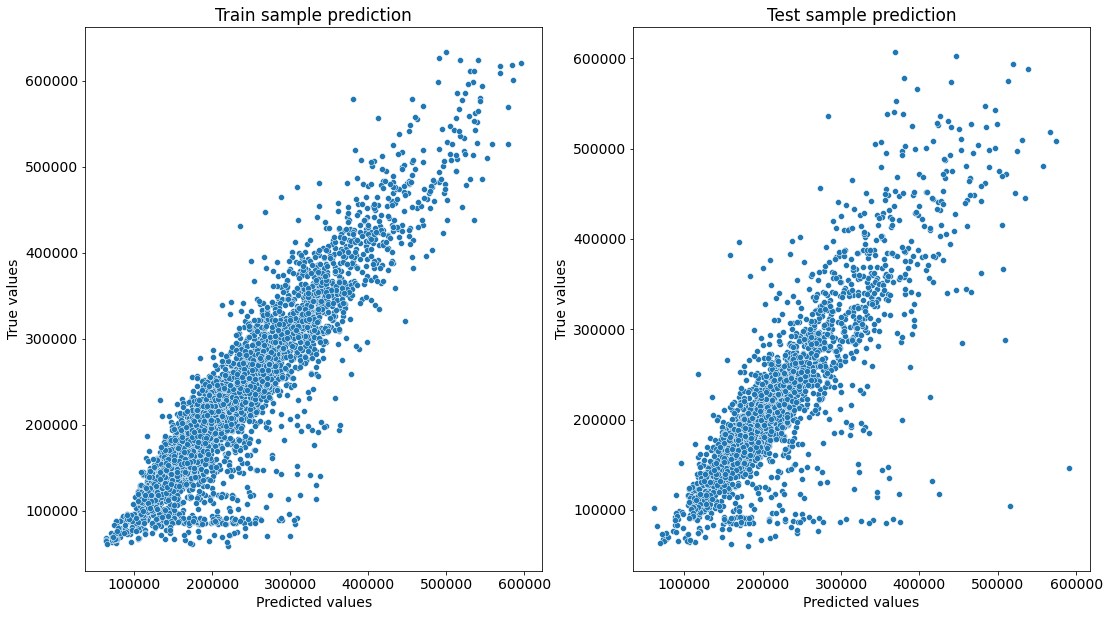

In [68]:
y_train_preds = best_model.predict(X_train)
y_test_preds = best_model.predict(X_test)
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [69]:
cv_score = cross_val_score(
    best_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.74223038, 0.72225487, 0.76744316, 0.78201428, 0.79767493])

In [70]:
cv_score.mean(), cv_score.std()

(0.7623235248559764, 0.027103099815920132)

In [71]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7352204250400562, 0.7894266246718966)

**Важность признаков**

In [72]:
feature_importances = pd.DataFrame(zip(X_train.columns, best_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,292
19,mean_price_dr,245
6,HouseYear,211
7,Ecology_1,132
5,HouseFloor,117
12,Social_3,115
3,KitchenSquare,95
13,Healthcare_1,95
2,LifeSquare,94
4,Floor,90


## Формирование файла с прогнозами

In [73]:
def to_csv(df, pred):
    test_id = df["Id"]
    pred_df = pd.DataFrame()
    pred_df["Id"] = test_id
    pred_df["Price"] = pred
    print(pred_df)
    pred_df.to_csv("./data/ASerebryakov_predictions.csv", index=False)

In [74]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,mean_price_dr,mean_price_by_rooms
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,B,1,1,1,91,0,174699.141564,216130.550208
1,15856,74,2.0,69.263183,35.066336,1.0,6,6.0,1977,0.075779,...,0,2,B,1,1,1,61,0,235072.859606,216130.550208
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,5,5,B,1,1,1,2,0,161436.065794,161436.065794
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,B,1,1,1,49,0,206507.966738,216130.550208
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,0,A,1,1,0,391,1,124081.144282,161436.065794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,1,1,B,1,1,1,45,0,252702.526957,290603.680350
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,0,1,B,1,1,1,344,1,146304.124870,161436.065794
4997,5783,12,3.0,77.842178,48.282625,9.0,23,23.0,1989,0.090799,...,5,15,B,1,1,1,36,0,292083.185793,290603.680350
4998,4780,62,2.0,81.305222,35.066336,0.0,4,12.0,1977,0.072158,...,0,0,A,1,1,0,122,1,194607.123960,216130.550208


In [75]:
X_test_df = test_df[feature_names + new_feature_names] # убираем лишние параметры
y_res_preds = best_model.predict(X_test_df) # делаем предсказание

In [76]:
to_csv(test_df, y_res_preds) # сохраняем в файл

         Id          Price
0       725  160474.097011
1     15856  226310.049902
2      5480  177245.106309
3     15664  303155.837789
4     14275  138611.875519
...     ...            ...
4995   8180  235173.391883
4996   4695  138191.594590
4997   5783  330834.078359
4998   4780  198029.148101
4999  12504  177783.232585

[5000 rows x 2 columns]
